Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: Policy Search

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The player taking the last object wins.

* Task3.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task3.2: An agent using evolved rules
* Task3.3: An agent using minmax
* Task3.4: An agent using reinforcement learning

## Instructions

* Create the directory `lab3` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.

**Deadline**

T.b.d.


In [1]:
import logging
from typing import Callable
from collections import namedtuple
import random
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm

In [2]:
Nimply = namedtuple("Nimply", "row, num_objects")

#### **Define Nim class**

In [3]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        """
        Initialize the Nim class by defining:
        - num_rows: the number of rows the game will have
        - k: the maximum number of elements that a player can remove
        """
        self._rows = [i*2 + 1 for i in range(num_rows)]
        self._k = k
        self._winner = None

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    @property
    def k(self) -> int:
        return self._k

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

    def display_board(self) -> None:
        for i in range(len(self._rows)):
            print(f"row[{i+1}]:  \t" + "| " * self._rows[i])

    def set_winner(self, winner: int) -> None:
        self._winner = winner

    @property
    def winner(self) -> int:
        return self._winner

#### Additional utility functions

In [4]:
import functools
from collections import Counter

def calc_nimsum(rows: tuple) -> int:
    return functools.reduce(lambda a, b: a ^ b, rows)

def all_ones(board: Nim) -> bool:
    counts = Counter(board.rows)
    for idx, cnt in counts.items():
        if idx == 0 or idx == 1:
            continue
        if cnt != 0:
            return False
    return True

def game_over(board: Nim, players: tuple, turn: int) -> bool:
    # The game is over when there are no objects left
    obj_left = sum(board.rows)
    if obj_left > 0:
        return False
    logging.debug(f"Game Over: {players[(turn + 1) % 2]} wins!")
    board.set_winner((turn + 1) % 2)
    return True

#### **Expert's Strategy**

In [5]:
def expert_strategy(board: Nim) -> Nimply:

    # Before checking nimsum, make sure that heap sizes are between 0 and k
    if board.k is not None:
        one_gt_k = False
        for i in range(len(board.rows)):
            # if a heap-size greater than k
            if board.rows[i] > board.k:
                one_gt_k = True
                # Try to take number of objects n such that n mod (k+1) = 0
                if board.rows[i] % (board.k + 1) != 0:
                    ply = Nimply(i, board.rows[i] % (board.k + 1))
                    logging.debug(f"Expert removed {board.rows[i] % (board.k + 1)}, from row {i+1}")
                    return ply
                # No optimal move, try with other heaps

        # No ideal move, make random move
        if one_gt_k:
            logging.debug(f"No ideal move found")
            # TODO: imporove strategy (take largest and remove one)
            idx = board.rows.index(max(board.rows))
            ply = Nimply(idx, board.k)
            logging.debug(f"Expert removed 1, from row {idx+1}")
            return ply


    board_nimsum = calc_nimsum(board.rows)

    # When the number of heaps with at least 2 objects is equal to 1
    if functools.reduce(lambda acc, el: acc + 1 if el > 1 else acc, board.rows, 0) == 1:
        # Count the number of heaps with one object
        # if the number is odd...
        if functools.reduce(lambda acc, el: acc + 1 if el == 1 else acc, board.rows, 0) % 2 != 0:
            # ...take all but one of the "non equal to one" heap
            for i in range(len(board.rows)):
                if board.rows[i] != 0 and board.rows[i] != 1:
                    ply = Nimply(i, board.rows[i]-1)
                    logging.debug(f"Expert removed {board.rows[i]-1}, from row {i+1}")
                    return ply
        # if the number is even...
        else:
             # ...take all of the "non equal to one" heap
            for i in range(len(board.rows)):
                if board.rows[i] != 0 and  board.rows[i] != 1:
                    ply = Nimply(i, board.rows[i])
                    logging.debug(f"Expert removed {board.rows[i]}, from row {i+1}")
                    return ply

    # Check if all the remaining heaps are composed of one element
    if all_ones(board):
        for i in range(len(board.rows)):
            if board.rows[i] == 1:
                ply = Nimply(i, 1)
                logging.debug(f"Expert removed 1, from row {i+1}")
                return ply
            
    chosen_idx = None
    for i in range(len(board.rows)): 
        logging.debug(f"nimsum ({board_nimsum}) XOR row[{i}] ({board.rows[i]}) = {board_nimsum ^ board.rows[i]}")
        if board_nimsum ^ board.rows[i] < board.rows[i]:
            chosen_idx = i
            break

    if chosen_idx is None:
        logging.debug(f"No ideal move found")
        # TODO: imporove strategy (take largest and remove one)
        idx = board.rows.index(max(board.rows))
        ply = Nimply(idx, 1)
        logging.debug(f"Expert removed 1, from row {idx+1}")
        return ply
    else:
        num_to_remove = board.rows[chosen_idx] - (board.rows[chosen_idx] ^ board_nimsum)
        ply = Nimply(chosen_idx, num_to_remove)
        logging.debug(f"Expert removed {num_to_remove}, from row {chosen_idx+1}")
        return ply
        

### **Other hard-coded strategies**

#### **SemiExpert A**
Does not take k bound into account (if there is a row with more than k elements, chooses randomly)
- *Not relevant with last instruction given by professor not to take k into account*

In [6]:
def semiexpert_A_strategy(board: Nim) -> Nimply:

    # Before checking nimsum, make sure that heap sizes are between 0 and k
    if board.k is not None:
        for i in range(len(board.rows)):
            # if a heap-size greater than k
            if board.rows[i] > board.k:
                # Remove random number from that row
                ply = Nimply(i, random.randint(1, board.k))
                logging.debug(f"SemiExpert A removed {board.rows[i] % (board.k + 1)}, from row {i+1}")
                return ply


    board_nimsum = calc_nimsum(board.rows)

    # When the number of heaps with at least 2 objects is equal to 1
    if functools.reduce(lambda acc, el: acc + 1 if el > 1 else acc, board.rows, 0) == 1:
        # Count the number of heaps with one object
        # if the number is odd...
        if functools.reduce(lambda acc, el: acc + 1 if el == 1 else acc, board.rows, 0) % 2 != 0:
            # ...take all but one of the "non equal to one" heap
            for i in range(len(board.rows)):
                if board.rows[i] != 0 and board.rows[i] != 1:
                    ply = Nimply(i, board.rows[i]-1)
                    logging.debug(f"SemiExpert A removed {board.rows[i]-1}, from row {i+1}")
                    return ply
        # if the number is even...
        else:
             # ...take all of the "non equal to one" heap
            for i in range(len(board.rows)):
                if board.rows[i] != 0 and  board.rows[i] != 1:
                    ply = Nimply(i, board.rows[i])
                    logging.debug(f"SemiExpert A removed {board.rows[i]}, from row {i+1}")
                    return ply

    # Check if all the remaining heaps are composed of one element
    if all_ones(board):
        for i in range(len(board.rows)):
            if board.rows[i] == 1:
                ply = Nimply(i, 1)
                logging.debug(f"SemiExpert A removed 1, from row {i+1}")
                return ply
            
    chosen_idx = None
    for i in range(len(board.rows)): 
        logging.debug(f"nimsum ({board_nimsum}) XOR row[{i}] ({board.rows[i]}) = {board_nimsum ^ board.rows[i]}")
        if board_nimsum ^ board.rows[i] < board.rows[i]:
            chosen_idx = i
            break

    if chosen_idx is None:
        logging.debug(f"No ideal move found")
        # TODO: imporove strategy (take largest and remove one)
        idx = board.rows.index(max(board.rows))
        ply = Nimply(idx, 1)
        logging.debug(f"SemiExpert A removed 1, from row {idx+1}")
        return ply
    else:
        num_to_remove = board.rows[chosen_idx] - (board.rows[chosen_idx] ^ board_nimsum)
        ply = Nimply(chosen_idx, num_to_remove)
        logging.debug(f"SemiExpert A removed {num_to_remove}, from row {chosen_idx+1}")
        return ply

#### **SemiExpert B**
Does not take ending strategies into account
- *Still too expert for evolution purposes*

In [7]:
def semiexpert_B_strategy(board: Nim) -> Nimply:

    # Before checking nimsum, make sure that heap sizes are between 0 and k
    if board.k is not None:
        opt_move = False
        for i in range(len(board.rows)):
            # if a heap-size greater than k
            if board.rows[i] > board.k:
                # Try to take number of objects n such that n mod (k+1) = 0
                if board.rows[i] % (board.k + 1) != 0:
                    ply = Nimply(i, board.rows[i] % (board.k + 1))
                    logging.debug(f"SemiExpert B removed {board.rows[i] % (board.k + 1)}, from row {i+1}")
                    opt_move = True
                    return ply
                # No optimal move, try with other heaps

        # No ideal move, make random move
        if not opt_move:
            logging.debug(f"No ideal move found")
            # TODO: imporove strategy (take largest and remove one)
            idx = board.rows.index(max(board.rows))
            ply = Nimply(idx, 1)
            logging.debug(f"SemiExpert B removed 1, from row {idx+1}")
            return ply


    board_nimsum = calc_nimsum(board.rows)

    chosen_idx = None
    for i in range(len(board.rows)): 
        logging.debug(f"nimsum ({board_nimsum}) XOR row[{i}] ({board.rows[i]}) = {board_nimsum ^ board.rows[i]}")
        if board_nimsum ^ board.rows[i] < board.rows[i]:
            chosen_idx = i
            break

    if chosen_idx is None:
        logging.debug(f"No ideal move found")
        # TODO: imporove strategy (take largest and remove one)
        idx = board.rows.index(max(board.rows))
        ply = Nimply(idx, 1)
        logging.debug(f"SemiExpert B removed 1, from row {idx+1}")
        return ply
    else:
        num_to_remove = board.rows[chosen_idx] - (board.rows[chosen_idx] ^ board_nimsum)
        ply = Nimply(chosen_idx, num_to_remove)
        logging.debug(f"SemiExpert B removed {num_to_remove}, from row {chosen_idx+1}")
        return ply

#### **Pure Random**

In [8]:
def pure_random(state: Nim) -> Nimply:
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row] if state.k is not None and state.rows[row] < state.k else state.k if state.k is not None else state.rows[row])
    return Nimply(row, num_objects)

#### Cook status
Generate some sort of summary of the game

In [9]:
def cook_status(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) if state.k is None or o <= state.k
    ]
    cooked["active_rows_number"] = sum(o > 0 for o in state.rows)
    cooked["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    cooked["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]
    cooked["nim_sum"] = calc_nimsum(state.rows)
    cooked["only_one_row_gt_one"] = functools.reduce(lambda acc, el: acc + 1 if el > 1 else acc, state.rows, 0) == 1
    cooked["active_rows_gt_one"] = functools.reduce(lambda acc, el: acc + 1 if el > 1 else acc, state.rows, 0)
    cooked["num_of_rows_eq_one"] = functools.reduce(lambda acc, el: acc + 1 if el == 1 else acc, state.rows, 0)
    cooked["all_rows_ones"] = all_ones(state)
    if state.k is not None:
        cooked["num_rows_gt_k"] = sum(o > state.k for o in state.rows)
        

    return cooked

### **Level 0 Strategy**
Aims at playing in such a way to allow the other to win
(Evolutionary algorithm should learn it should take all elements from last row)

In [10]:
def level_zero(state: Nim) -> Nimply:
    data = cook_status(state)
    if data["active_rows_number"] == 1 and state.rows[data["shortest_row"]] > 1:
        return Nimply(data["shortest_row"], state.rows[data["shortest_row"]] - 1)
    else:
        return Nimply(data["longest_row"], 1)

### **Level 2 Strategy**
Random strategy is considered level one (given it wins on average over level 0)
- This strategy takes into account almost final scenarios (where all rows have one or no elements and only one has more than one element)
- It also wins if only one row is left
- In other scenarios tries to make some "silly" decisions

In [11]:
def level_two(state: Nim) -> Nimply:
    data = cook_status(state)
    if data["active_rows_number"] == 1 and state.rows[data["shortest_row"]] > 1:
        return Nimply(data["shortest_row"], state.rows[data["shortest_row"]])
    elif data["only_one_row_gt_one"] and data["num_of_rows_eq_one"] % 2 == 0:
        for i in range(len(state.rows)):
            if state.rows[i] != 0 and  state.rows[i] != 1:
                return Nimply(i, state.rows[i])
    elif data["only_one_row_gt_one"] and data["num_of_rows_eq_one"] % 2 != 0: 
        for i in range(len(state.rows)):
            if state.rows[i] != 0 and  state.rows[i] != 1:
                return Nimply(i, state.rows[i] - 1)
    else:
        if state.rows[data["longest_row"]] > 2:
            return Nimply(data["longest_row"], state.rows[data["longest_row"]] - 2)
        elif state.rows[data["longest_row"]] == 2:
            return Nimply(data["longest_row"], state.rows[data["longest_row"]] - 1)
        else:
            return Nimply(data["longest_row"], 1)

### **Level 3 Strategy**
As level 2 stategy, but:
- Aims to reach the configuration to use "final scenario" conditions (i.e tries to have an even or odd number of rows wth single object by leaving two objects in the rows)

In [12]:
def level_three(state: Nim) -> Nimply:
    data = cook_status(state)
    if data["active_rows_number"] == 1 and state.rows[data["shortest_row"]] > 1:
        return Nimply(data["shortest_row"], state.rows[data["shortest_row"]])
    elif data["only_one_row_gt_one"] and data["num_of_rows_eq_one"] % 2 == 0:
        for i in range(len(state.rows)):
            if state.rows[i] != 0 and  state.rows[i] != 1:
                return Nimply(i, state.rows[i])
    elif data["only_one_row_gt_one"] and data["num_of_rows_eq_one"] % 2 != 0: 
        for i in range(len(state.rows)):
            if state.rows[i] != 0 and  state.rows[i] != 1:
                return Nimply(i, state.rows[i] - 1)
    else:
        return Nimply(data["longest_row"], 1)

#### **Human Move** (requires input)

In [13]:
def make_human_move(board: Nim) -> Nimply:
    selected_row = -1
    while selected_row < 0 or selected_row > len(board.rows) or board.rows[selected_row] == 0:
        selected_row = int(input(f"Select heap from which you want to remove objects [1-{len(board.rows)}]")) - 1
        if selected_row < 0 or selected_row > len(board.rows) or board.rows[selected_row] == 0:
            print(f"Invalid row number (the row number might be correct, but there are no objects left in row)\n")
    
    num_objs = 0
    while num_objs <= 0 or num_objs > board.rows[selected_row]:
        num_objs = int(input(f"How many objects do you want to remove [1-{board.rows[selected_row]}]?"))
        if num_objs <= 0 or num_objs > board.rows[selected_row]:
            print(f"Invalid number of objects to be removed\n")
    
    ply = Nimply(selected_row, num_objs)
    print(f"You have removed {num_objs}, from row {selected_row+1}")
    return ply

### **Play Match**

In [14]:
def play_nim(num_of_heaps: int, a: Callable, b: Callable, k = None, display_board=False) -> None:
    nim = Nim(num_of_heaps, k)
    if display_board:
        nim.display_board()
    strategies = (a, b)
    
    players = ['a', 'b']
    turn = 0
    while not game_over(nim, players, turn):
        ply = strategies[turn](nim)
        nim.nimming(ply)
        if display_board:
            nim.display_board()
        turn = (turn + 1) % 2
    return nim.winner

In [15]:
logging.getLogger().setLevel(logging.INFO)
play_nim(20, expert_strategy, pure_random)

0

### **Evaluation**

In [16]:
NUM_MATCHES = 10

def evaluate(strategy: Callable, other_strategy: Callable, k=None, nim_size=10) -> float:
    won_1 = 0
    won_2 = 0

    for _ in range(NUM_MATCHES):
        winner_first = play_nim(nim_size, strategy, other_strategy, k)
        winner_second = play_nim(nim_size, other_strategy, strategy, k)
        if winner_first == 0:
            won_1 += 1
        if winner_second == 1:
            won_2 += 1
    return won_1 / NUM_MATCHES, won_2 / NUM_MATCHES

Evaluation Example

In [17]:
NIM_SIZE = [5, 10, 13, 15]
logging.getLogger().setLevel(logging.INFO)

sum_eval_first = 0
sum_eval_second = 0
for nim_size in NIM_SIZE: 
    eval = evaluate(level_three, pure_random, k=None, nim_size=nim_size)
    #print(f"eval for nim_size {nim_size}: {eval}")
    sum_eval_first += eval[0]
    sum_eval_second += eval[1]
avg_eval = sum_eval_first / len(NIM_SIZE), sum_eval_second / len(NIM_SIZE)
avg_eval

(0.925, 0.95)

## **EVOLUTION**

Define rules

In [44]:
class Rules:
    def __init__(self) -> None:
        self._rule_dict = {
            1: self.rule_1,
            2: self.rule_2,
            3: self.rule_3,
            4: self.rule_4,
            5: self.rule_5,
        }
        self._fired_times = {
            1: 0,
            2: 0,
            3: 0,
            4: 0,
            5: 0,
        }

    @property
    def rule_dict(self) -> int:
        return self._rule_dict
        
    @property
    def fired_times(self) -> int:
        return self._fired_times

    def rule_1(self, state, data):
        if data["active_rows_number"] == 1 and state.rows[data["shortest_row"]] > 1:
                return Nimply(data["shortest_row"], state.rows[data["shortest_row"]])
        else:
            return None

    def rule_2(self, state, data):
        if data["only_one_row_gt_one"] and data["num_of_rows_eq_one"] % 2 == 0:
                for i in range(len(state.rows)):
                    if state.rows[i] != 0 and  state.rows[i] != 1:
                        return Nimply(i, state.rows[i])
        else:
            return None

    def rule_3(self, state, data):
        if data["only_one_row_gt_one"] and data["num_of_rows_eq_one"] % 2 != 0: 
                for i in range(len(state.rows)):
                    if state.rows[i] != 0 and  state.rows[i] != 1:
                        return Nimply(i, state.rows[i] - 1)
        else:
            return None

    def rule_4(self, state, data):
        if state.rows[data["longest_row"]] >= 2:
                if state.rows[data["longest_row"]] > 2:
                    return Nimply(data["longest_row"], state.rows[data["longest_row"]] - 2)
                elif state.rows[data["longest_row"]] == 2:
                    return Nimply(data["longest_row"], state.rows[data["longest_row"]] - 1)
                else:
                    return Nimply(data["longest_row"], 1)
        else:
            return None

    def rule_5(self, state, data):
        return None
        if data["nim_sum"] != 0:
            chosen_idx = 0
            for i in range(len(state.rows)): 
                if data["nim_sum"] ^ state.rows[i] < state.rows[i]:
                    chosen_idx = i
                    break
            num_to_remove = state.rows[chosen_idx] - (state.rows[chosen_idx] ^ data["nim_sum"])
            return Nimply(chosen_idx, num_to_remove)
        else:
            return None


Skeleton of a parametrized strategy

In [19]:
def make_strategy(genome: list, rules: Rules) -> Callable:

    def evolved_strategy(state: Nim) -> Nimply:
        data = cook_status(state)

        # define order of rules given a permutation seed
        rules_idxs = list(rules.rule_dict.keys())
        seed = np.abs(genome[0].astype(int)*np.random.randint(1, 512))
        np.random.seed(seed)
        order = np.random.permutation(rules_idxs)

        # call a rule according to genome probability in given order
        for rule_num in order:
            if random.random() < genome[rule_num]:
                rules.fired_times[rule_num] += 1
                ply =  rules.rule_dict[rule_num](state, data)
                if ply is not None:
                    return ply

        # if no rules called use last gene to select one of the rules to fire
        seed = np.abs(genome[0].astype(int)*np.random.randint(1, 512))
        np.random.seed(seed)
        rules.fired_times[rule_num] += 1
        ply = rules.rule_dict[np.random.randint(1, 6)](state, data)
        if ply is not None:
            return ply
        else:
            return Nimply(data["longest_row"], 1)

    return evolved_strategy

#### Definition of Fitness and Genetic Operators

In [39]:
NIM_SIZE = [5, 10, 13, 20]
Individual = namedtuple("Individual", ["genome", "fitness"])

# Returns the fitness of given genome
def nim_fit(genome, strategy):
    rules = Rules()
    current = make_strategy(genome, rules)
    sum_eval_first = 0
    sum_eval_second = 0
    for nim_size in NIM_SIZE: 
        eval = evaluate(current, strategy, k=None, nim_size=nim_size)
        #logging.debug(f"eval for nim_size {nim_size}: {eval}")
        sum_eval_first += eval[0]
        sum_eval_second += eval[1]
    avg_eval = sum_eval_first / len(NIM_SIZE), sum_eval_second / len(NIM_SIZE)
    evaluations = (avg_eval[0] + avg_eval[1]) / 2
    # fitness is given by the avg winning rate against the strategy
    return evaluations


def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)


def cross_over(genome1, genome2, problem_size):
    cut = random.randint(0, problem_size)
    if random.randint(0, problem_size) % 3 == 0:
        return genome1[:cut] + genome2[cut:]
    elif random.randint(0, problem_size) % 3 == 2:
        return genome2[:cut] + genome1[cut:]
    else:
        return tuple(g1 if rand < 0.5 else g2 for g1, g2, rand in zip(genome1, genome2, np.random.random(problem_size)))


def mutation(genome, problem_size):
    point = random.randint(0, problem_size - 1)
    return genome[:point] + (1 - genome[point],) + genome[point + 1 :]

## Evolutionary Strategies

### **Adaptive (μ+λ)-ES**

In [61]:
logging.getLogger().setLevel(logging.INFO)


def adaptive_es(opponent_strategy, strategy_name, initial_population=None):
    # Population size
    μ = 5
    # Offspring size
    λ = 20
    # Initial adaptive mutation step
    σ = 1

    GENOME_DIM = 7

    if initial_population is None:
        population = np.random.random((μ, GENOME_DIM + 1))
        population[:, :-1] = population[:, :-1] * 5.12 * 2 - 5.12
        population[:, -1] *= σ
    else:
        population = initial_population

    logging.debug(f"Pop shape {population.shape}")

    best_fitness = None
    history = list()
    for step in tqdm(range(2_000 // λ)):
        # offspring <- select λ random points from the population of μ
        offspring = population[np.random.randint(0, μ, size=(λ,))]

        # mutate all σ (last column) and replace negative values with a small number
        offspring[:, -1] = np.random.normal(loc=offspring[:, -1], scale=0.2)
        offspring[offspring[:, -1] < 1e-5, -1] = 1e-5
        
        # mutate all v (all columns but the last), using the σ in the last column
        offspring[:, 0:-1] = np.random.normal(loc=offspring[:, 0:-1], scale=offspring[:, -1].reshape(-1, 1))
        
        # add an extra column with the evaluation and sort
        fitness = []
        logging.debug(f"Offspring shape: {offspring.shape}")
        for i in range(λ):
            fitness.append(nim_fit(offspring[i, 0:-1], opponent_strategy))
        fitness = np.array(fitness)
        offspring = offspring[fitness.argsort()]
        
        # save best (just for the plot)
        if best_fitness is None or best_fitness < np.max(fitness):
            best_fitness = np.max(fitness)
            history.append((step, best_fitness))
            if best_fitness == 1.0:
                break
        
        # select the μ with max fitness and discard fitness
        population = np.copy(offspring[-μ:])

    logging.info(f"Against {strategy_name}")
    logging.info(f"Best solution fitness: {fitness.max()} (with σ={population[0, -1]:0.3g})")
    logging.debug(f"Best individual: {population[0,:-1]}")

    logging.debug(f"History:\n{history}")
    history = np.array(history)
    plt.figure(figsize=(14, 4))
    plt.plot(history[:, 0], history[:, 1], marker=".")
    
    return fitness.max(), population

### **Evolve Population**
The idea is to evolve the population in a progressive way, from the easiest strategy as an opponent, to the toughest

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Against level_zero
INFO:root:Best solution fitness: 1.0 (with σ=0.0567)


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Against pure_random
INFO:root:Best solution fitness: 1.0 (with σ=0.397)


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Against level_two
INFO:root:Best solution fitness: 0.725 (with σ=1e-05)


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Against level_three
INFO:root:Best solution fitness: 0.6125 (with σ=1e-05)


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Against expert_strategy
INFO:root:Best solution fitness: 0.0 (with σ=1e-05)
INFO:root:Final evolved individual: [-4.25575728  3.3086695   5.43112599  3.99465531 -7.32563323 -5.45279994
  4.27792562], (with σ=1e-05)


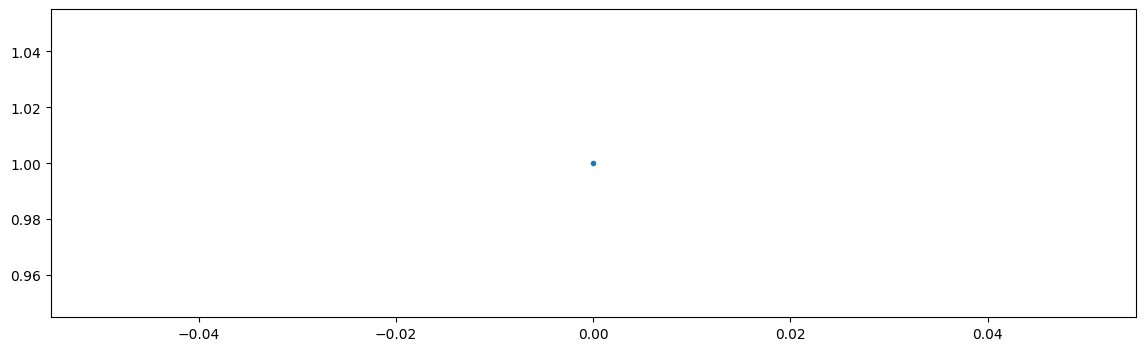

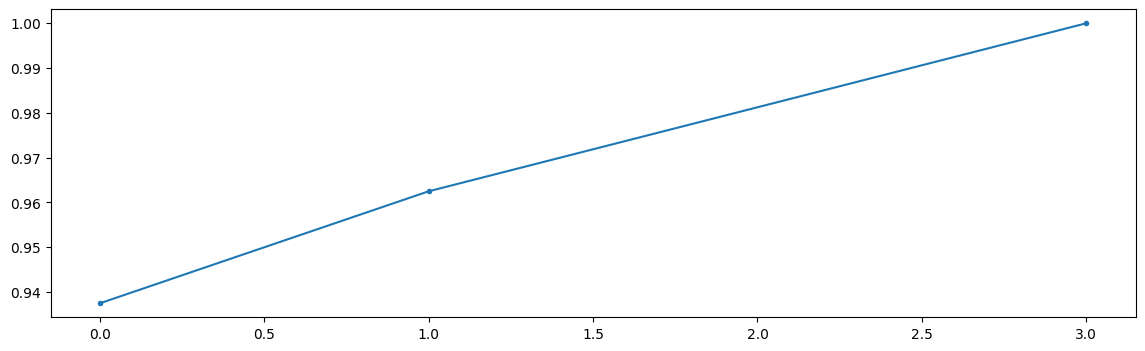

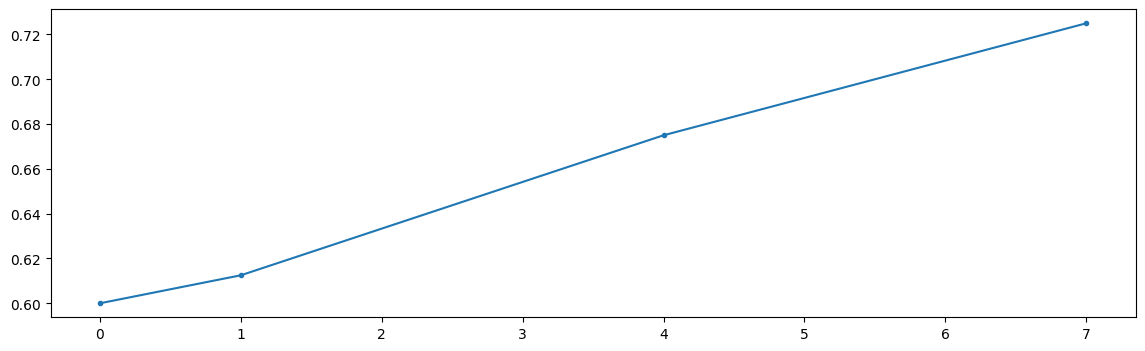

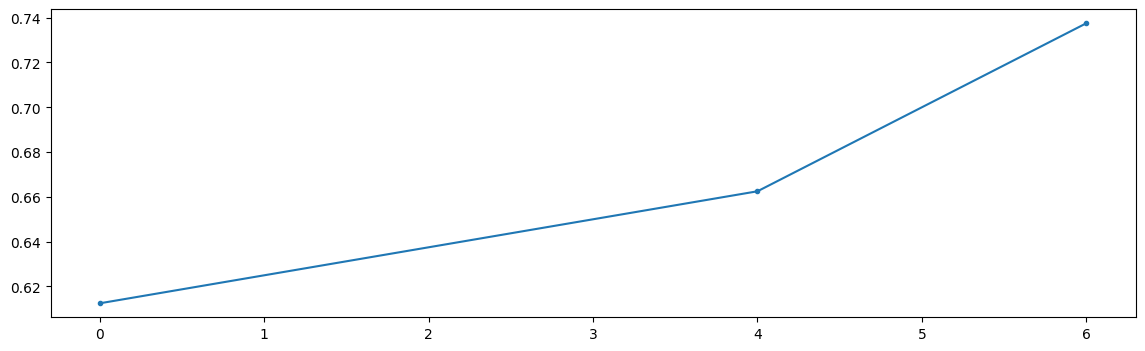

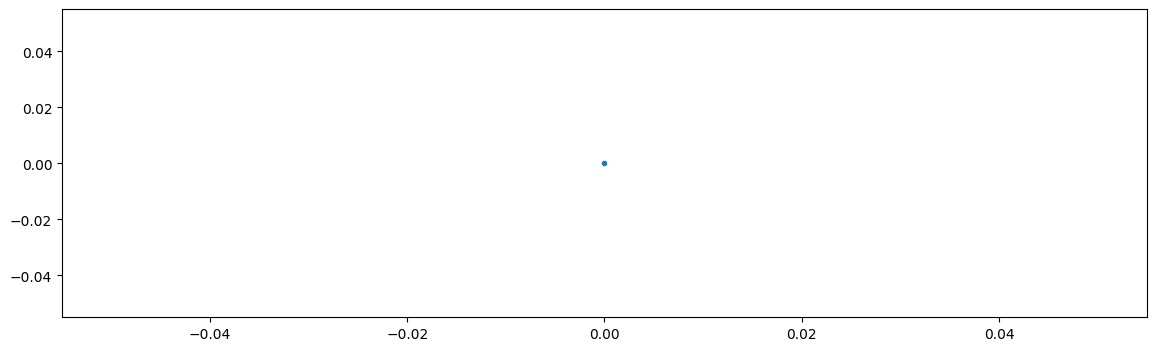

In [62]:
strategies = [level_zero, pure_random, level_two, level_three, expert_strategy]
strategy_names = ["level_zero", "pure_random", "level_two", "level_three", "expert_strategy"]

pop = None
for i, strategy in enumerate(strategies):
    max_fitness, pop = adaptive_es(strategy, strategy_names[i], pop)

logging.info(f"Final evolved individual: {pop[0,: -1]}, (with σ={pop[0, -1]:0.3g})")

Test the best solution

In [68]:
NIM_SIZE = [5, 10, 13, 15, 20]
logging.getLogger().setLevel(logging.INFO)

best = make_strategy(pop[0,: -1], Rules())

sum_eval_first = 0
sum_eval_second = 0
for nim_size in NIM_SIZE: 
    eval = evaluate(best, level_three, k=None, nim_size=nim_size)
    print(f"eval for nim_size {nim_size}: {eval}")
    sum_eval_first += eval[0]
    sum_eval_second += eval[1]
avg_eval = sum_eval_first / len(NIM_SIZE), sum_eval_second / len(NIM_SIZE)
avg_eval

eval for nim_size 5: (0.2, 0.7)
eval for nim_size 10: (0.0, 0.6)
eval for nim_size 13: (1.0, 1.0)
eval for nim_size 15: (1.0, 1.0)
eval for nim_size 20: (0.3, 0.4)


(0.5, 0.74)

### **Play Expert PC against Human Game**

In [ ]:
import time

def play_nim_human(num_of_heaps: int, first='human', display_board=False) -> None:
    nim = Nim(num_of_heaps)
    if display_board:
        nim.display_board()

    players = ['pc', 'human']

    if first == 'human':
        turn = 1
    else:
        turn = 0

    while not game_over(nim, players, turn):
        if players[turn] == 'pc':
            time.sleep(1)
            ply = expert_strategy(nim)
            nim.nimming(ply)
            if display_board:
                nim.display_board()
        if players[turn] == 'human':
            ply = make_human_move(nim)
            nim.nimming(ply)
            if display_board:
                nim.display_board()
        print("\n", end="\r")
        turn = (turn + 1) % 2

    return

In [ ]:
logging.getLogger().setLevel(logging.DEBUG)
play_nim_human(4, first='pc')